# **ЦЕЛЬ: Создать модель предсказания того, уйдёт ли абонент в отток (churn).**

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import PolynomialFeatures

In [4]:
df = pd.read_csv('Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# **Проведем первичный анализ данных**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


In [6]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [7]:
df.isna().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


<Axes: xlabel='Churn', ylabel='count'>

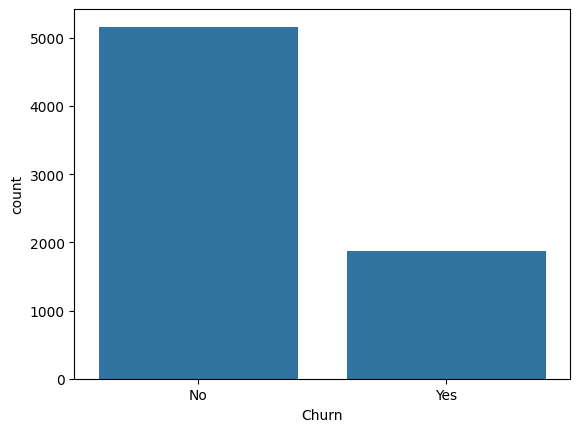

In [8]:
sns.countplot(data = df, x = 'Churn')

Высокий дисбаланс классов, что означает риск не правильных показатейлей метрики Accuracy

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


<Axes: xlabel='TotalCharges'>

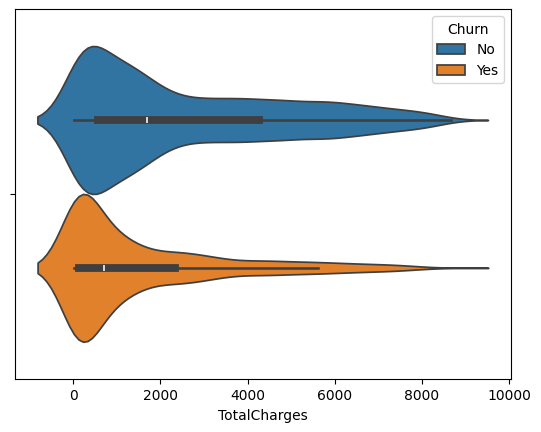

In [9]:
sns.violinplot(data = df, x = 'TotalCharges', hue = 'Churn',orient = 'v')

Заметим, что в среднем расходов больше у тех, кто не ушел в отток, что логично

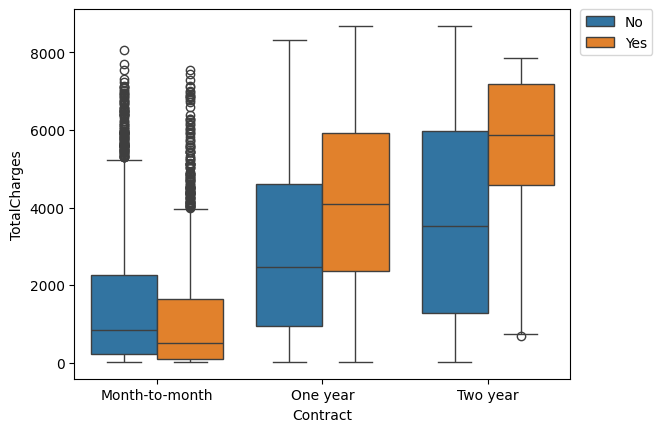

In [10]:
sns.boxplot(data = df, y = 'TotalCharges', x = 'Contract',hue = 'Churn')
plt.legend(bbox_to_anchor=( 1.02 , 1 ), loc='upper left', borderaxespad= 0)

Как мы видим, у людей чьи контракты были на один месяц и которые ушли в отток очень большие общие затраты, возможно функции которые им были необходимы слишком дорогие у данного оператора. Это касается и для остальных кагорт

# Проверим корреляцию между признаками

In [11]:
corr_df  = pd.get_dummies(df[['gender', 'SeniorCitizen', 'Partner', 'Dependents','PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport','StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod','Churn']]).corr()

In [72]:
corr = corr_df['Churn_Yes'].sort_values().iloc[1:-1].reset_index()
corr

,index,Churn_Yes
0,Contract_Two year,-0.301552
1,StreamingMovies_No internet service,-0.227578
2,StreamingTV_No internet service,-0.227578
3,TechSupport_No internet service,-0.227578
4,DeviceProtection_No internet service,-0.227578
5,OnlineBackup_No internet service,-0.227578
6,OnlineSecurity_No internet service,-0.227578
7,InternetService_No,-0.227578
8,PaperlessBilling_No,-0.191454
9,Contract_One year,-0.178225


<ipython-input-73-bfcc227e5c70>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = corr, x = 'index', y = 'Churn_Yes',palette="rocket_r")


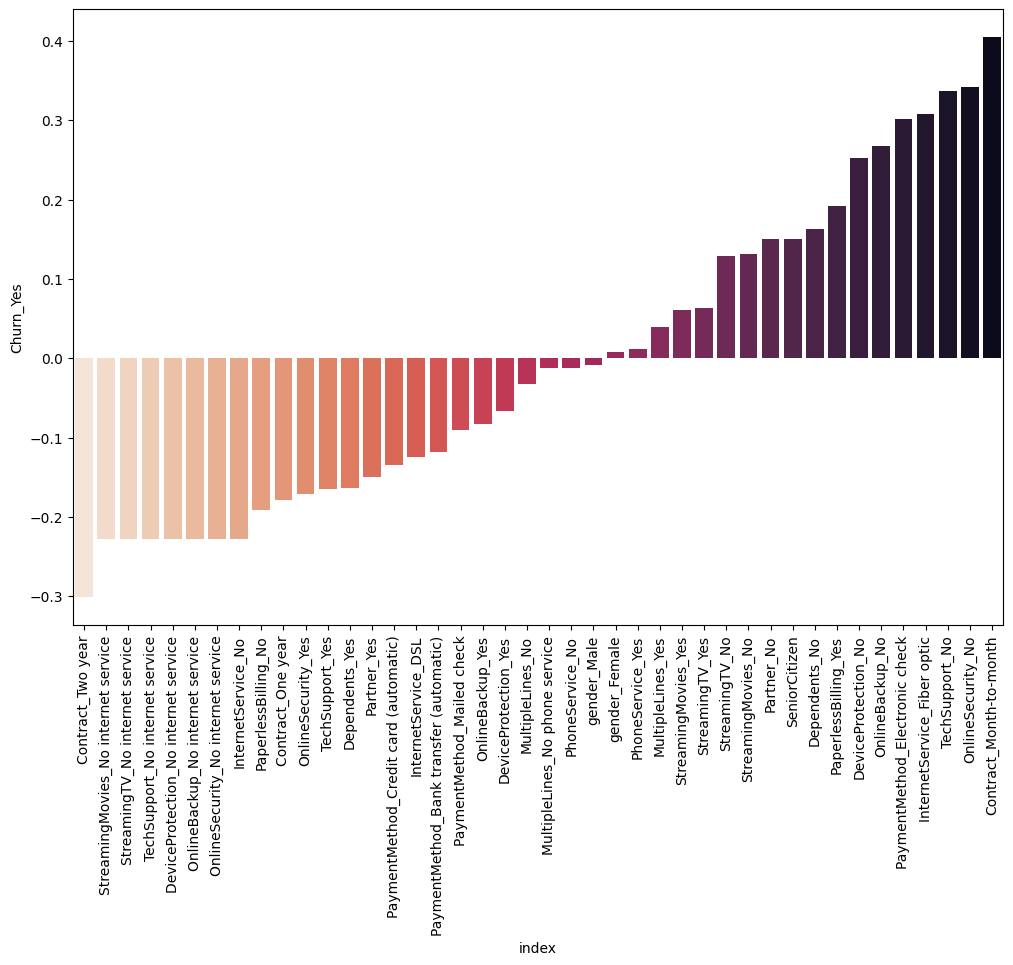

In [73]:
fig = plt.figure(figsize = (12,8))
sns.barplot(data = corr, x = 'index', y = 'Churn_Yes',palette="rocket_r")
plt.xticks(rotation=90);

Мы наблюдаем, что больше всего отписываются те люди, которые только месяц пользовались сервисом, но из-за которой срок пользования составил только один месяц в том, что:


1.   Нет онлайн защиты
2.   Нет технической поддержки
3. Нет защиты девайса



<Axes: xlabel='tenure', ylabel='Count'>

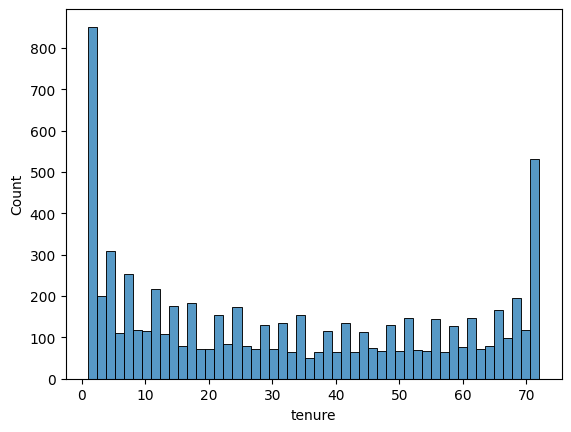

In [31]:
sns.histplot(data=df, x="tenure",bins = 50)

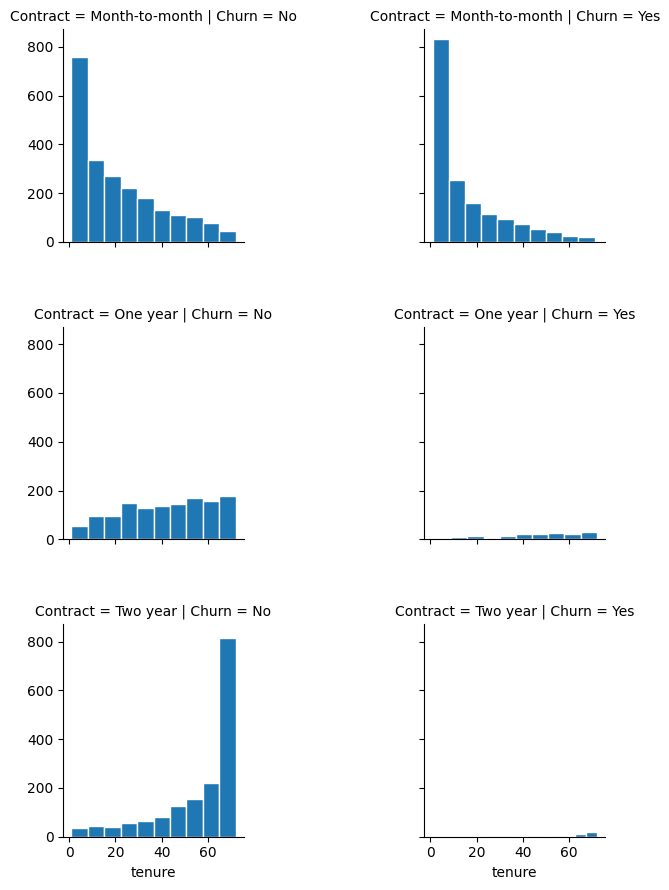

In [33]:
g = sns.FacetGrid(data=df,col='Churn',row='Contract')
g = g.map(plt.hist, "tenure", edgecolor="w")
g.add_legend()

plt.subplots_adjust(hspace=0.4, wspace=1)

Как мы видим, из всех новых пользователейполовина остается на сервисе, отток порльзователей которые пользуются сервисом более года минимальный

# **Feature engineering**

In [35]:
def tenureFunc(x):
  if 0 < x <=12:
    return '0-12 Months'
  elif 12<x<=24:
     return '12-24 Months'
  elif 24<x<48:
    return '24-48 Months'
  else:
    return 'Over 48 Months'
df['Tenure Cohort'] = df['tenure'].apply(tenureFunc)
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Tenure Cohort
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0-12 Months
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,24-48 Months
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,0-12 Months
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,24-48 Months
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0-12 Months
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No,12-24 Months
7028,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No,Over 48 Months
7029,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No,0-12 Months
7030,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes,0-12 Months


In [37]:
df_finally  = pd.get_dummies(df.drop('customerID',axis = 1),drop_first=True,dtype='int')
df_finally

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes,Tenure Cohort_12-24 Months,Tenure Cohort_24-48 Months,Tenure Cohort_Over 48 Months
0,0,1,29.85,29.85,0,1,0,0,1,0,...,0,0,1,0,1,0,0,0,0,0
1,0,34,56.95,1889.50,1,0,0,1,0,0,...,1,0,0,0,0,1,0,0,1,0
2,0,2,53.85,108.15,1,0,0,1,0,0,...,0,0,1,0,0,1,1,0,0,0
3,0,45,42.30,1840.75,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0
4,0,2,70.70,151.65,0,0,0,1,0,0,...,0,0,1,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,0,24,84.80,1990.50,1,1,1,1,0,1,...,1,0,1,0,0,1,0,1,0,0
7028,0,72,103.20,7362.90,0,1,1,1,0,1,...,1,0,1,1,0,0,0,0,0,1
7029,0,11,29.60,346.45,0,1,1,0,1,0,...,0,0,1,0,1,0,0,0,0,0
7030,1,4,74.40,306.60,1,1,0,1,0,1,...,0,0,1,0,0,1,1,0,0,0


# **Создадим модель на основе деревьев решений (Градиентый бустинг)**

In [39]:
X = df_finally.drop('Churn_Yes',axis = 1)
y = df_finally['Churn_Yes']

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [42]:
param_grid = {"n_estimators":[1,5,10,20,40,100],'max_depth':[3,4,5,6]}

In [43]:
gb_model = GradientBoostingClassifier()

In [44]:
grid = GridSearchCV(gb_model,param_grid)

In [45]:
grid.fit(X_train,y_train)

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': [3, 4, 5, 6],
                         'n_estimators': [1, 5, 10, 20, 40, 100]})

In [47]:
grid.best_params_

{'max_depth': 4, 'n_estimators': 40}

**оценка работы модели (вычеслим метрики)**

In [46]:
predictions = grid.predict(X_test)

In [49]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1580
           1       0.66      0.51      0.57       530

    accuracy                           0.81      2110
   macro avg       0.75      0.71      0.72      2110
weighted avg       0.80      0.81      0.80      2110



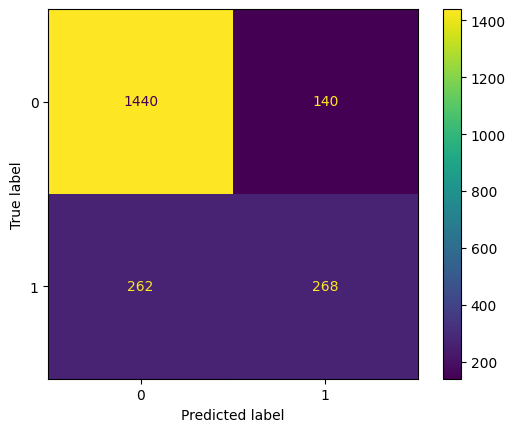

In [52]:
ConfusionMatrixDisplay.from_estimator(
    grid, X_test, y_test)

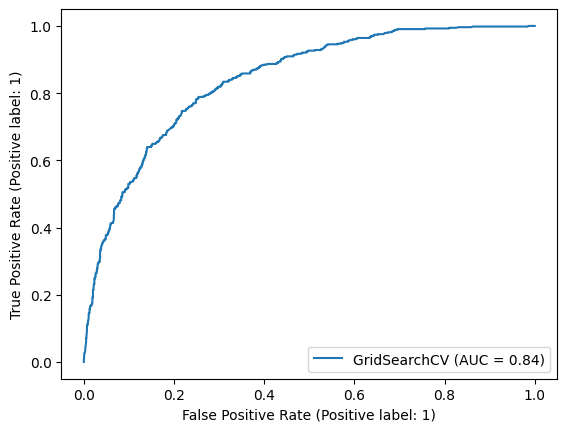

In [53]:
RocCurveDisplay.from_estimator(
   grid, X_test, y_test)

Как мы видим моденль очень хорошо предсказывает, что пользователь не ушел в отток, но плохо, что ушел (примерно 50% ошибок)

**Посмотрим какие признаки больше всего повлияли на результат**

In [54]:
grid.best_estimator_.feature_importances_

array([1.39566249e-02, 3.52589498e-01, 5.38186858e-02, 5.28547599e-02,
       1.22996791e-03, 0.00000000e+00, 2.50499400e-03, 3.53288353e-03,
       2.08686578e-03, 7.07377547e-03, 2.27313696e-01, 6.14495444e-03,
       1.17979857e-03, 1.34737475e-02, 7.93129676e-03, 3.33256284e-03,
       2.78500662e-03, 4.72454706e-04, 1.02181786e-03, 1.44312357e-02,
       4.07720171e-03, 1.04913229e-02, 4.96075619e-06, 4.08387862e-03,
       4.66933257e-02, 5.34769098e-02, 1.74429474e-02, 1.88503459e-03,
       9.06621271e-02, 1.23552303e-03, 1.11772603e-03, 2.37570257e-04,
       8.56845502e-04])

In [59]:
feat_import = sorted(grid.best_estimator_.feature_importances_,reverse = True)
imp_feats = pd.DataFrame(index=X.columns,data=feat_import,columns=['Importance'])
imp_feats  = imp_feats.loc[(imp_feats.Importance >= 0.01)]
imp_feats

,Importance
SeniorCitizen,0.352589
tenure,0.227314
MonthlyCharges,0.090662
TotalCharges,0.053819
gender_Male,0.053477
Partner_Yes,0.052855
Dependents_Yes,0.046693
PhoneService_Yes,0.017443
MultipleLines_No phone service,0.014431
MultipleLines_Yes,0.013957


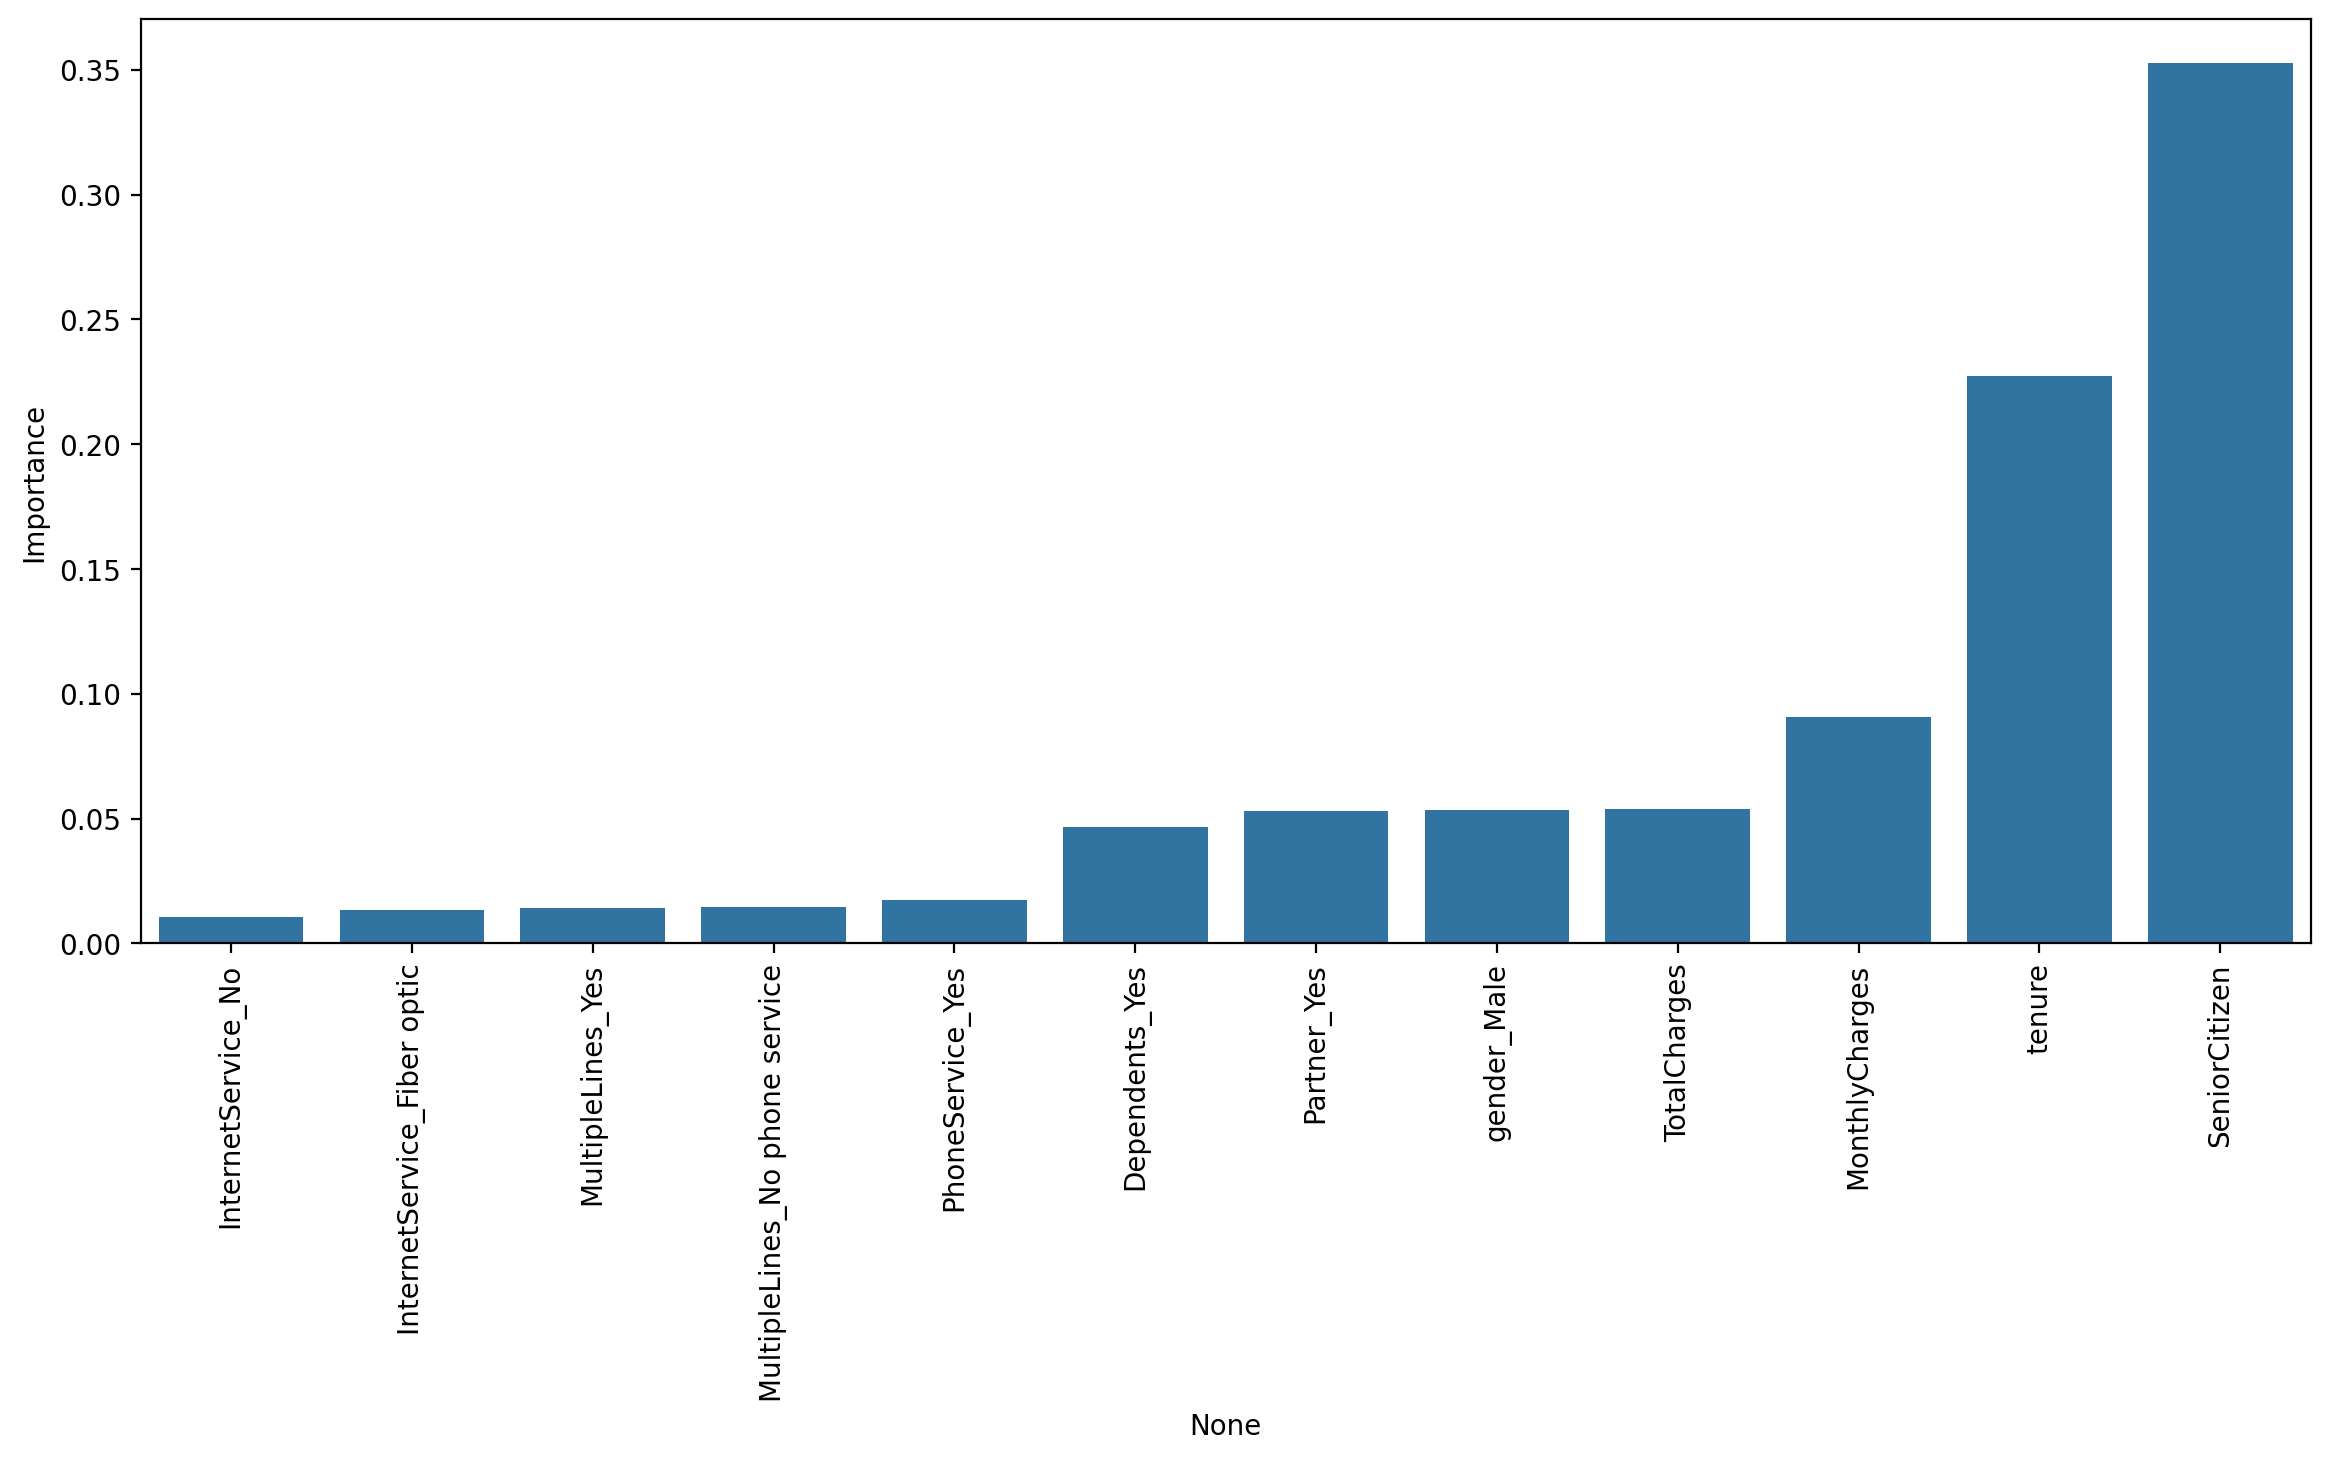

In [60]:
plt.figure(figsize=(14,6),dpi=200)
sns.barplot(data=imp_feats.sort_values('Importance'),x=imp_feats.sort_values('Importance').index,y='Importance')
plt.xticks(rotation=90);